In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from glob import glob

In [2]:
IMAGE_SIZE = [224, 224]
train_path = 'Dataset_Banana/train'
valid_path = 'Dataset_Banana/test'

In [3]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [4]:
for layer in resnet.layers:
    layer.trainable = False

In [5]:
folders = glob('Dataset_Banana/train/*')

In [6]:
print(folders)

['Dataset_Banana/train\\Fresh Banana', 'Dataset_Banana/train\\Rotten Banana']


In [7]:
x = Flatten()(resnet.output)

In [8]:
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=resnet.input, outputs=prediction)

In [9]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

__________________________________________________________________________________________________
conv4_block5_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block5_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block5_1_relu (Activation (None, 14, 14, 256)  0           conv4_block5_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block5_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block5_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block5_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block5_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block5_2_relu (Activation (None, 14, 14, 256)  0           conv4_block5_2_bn[0][0]          
__________

In [10]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
training_set = train_datagen.flow_from_directory('Dataset_Banana/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 3805 images belonging to 2 classes.


In [13]:
test_set = test_datagen.flow_from_directory('Dataset_Banana/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 910 images belonging to 2 classes.


In [14]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
119/119 [==============================] - 751s 6s/step - loss: 0.9592 - accuracy: 0.7501 - val_loss: 0.3476 - val_accuracy: 0.8516
Epoch 2/5
119/119 [==============================] - 612s 5s/step - loss: 0.3716 - accuracy: 0.8510 - val_loss: 0.2748 - val_accuracy: 0.8989
Epoch 3/5
119/119 [==============================] - 441s 4s/step - loss: 0.3234 - accuracy: 0.8723 - val_loss: 0.3425 - val_accuracy: 0.8868
Epoch 4/5
119/119 [==============================] - 441s 4s/step - loss: 0.2200 - accuracy: 0.9148 - val_loss: 0.5697 - val_accuracy: 0.7769
Epoch 5/5
119/119 [==============================] - 422s 4s/step - loss: 0.2766 - accuracy: 0.8930 - val_loss: 0.2418 - val_accuracy: 0.8835


In [15]:
model.evaluate(test_set)

29/29 [==============================] - 75s 3s/step - loss: 0.2418 - accuracy: 0.8835


[0.24184778332710266, 0.8835164904594421]

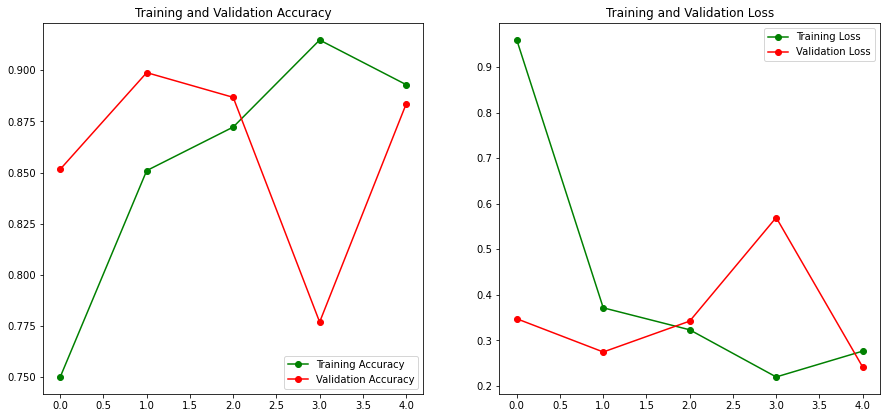

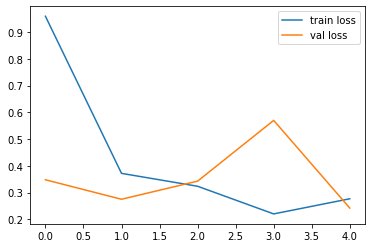

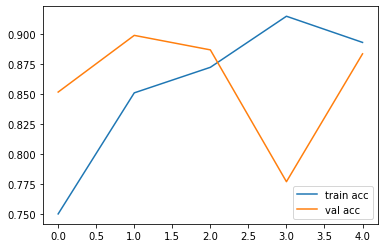

<Figure size 432x288 with 0 Axes>

In [33]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc,"go-", label='Training Accuracy')
plt.plot(epochs_range, val_acc,"ro-", label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.savefig('AccurateValue_acc_points')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss,"go-", label='Training Loss')
plt.plot(epochs_range, val_loss,"ro-", label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('LossValue_loss_points')

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss_withoutPoints')

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc_withoutPoints')

In [19]:
test_pred = model.predict(test_set)

In [20]:
output = [np.argmax(op) for op in test_pred]
df_output = pd.DataFrame(output)
print(df_output.value_counts())

0    462
1    448
dtype: int64


In [21]:
def img_preprocessing(path):
    sample_mask_img = cv2.imread(path)
    sample_mask_img = cv2.resize(sample_mask_img,(224,224))
    plt.imshow(sample_mask_img)
    sample_mask_img = np.reshape(sample_mask_img,[1,224,224,3])
    sample_mask_img = sample_mask_img/255.0
    res = np.argmax(model.predict(sample_mask_img))
    print(res)

0


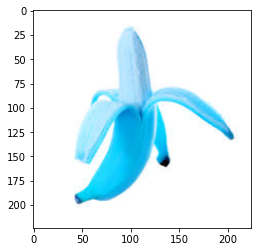

In [32]:
img_preprocessing('Dataset_Banana/single_prediction/freshbanana/fresh1.jpg')